In [7]:
!pip install -Uqq ddgs fastai

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from ddgs import DDGS 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

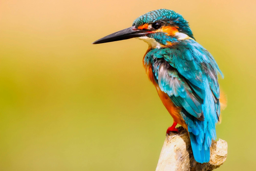

In [4]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

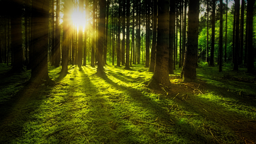

In [5]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [8]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

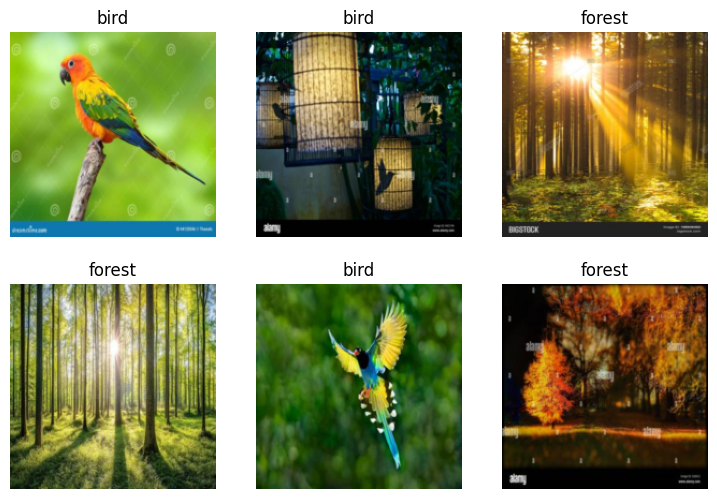

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [11]:

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.521613,0.144642,0.063953,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.099554,0.042429,0.014535,00:03
1,0.064062,0.013353,0.002907,00:03
2,0.040589,0.026364,0.011628,00:03
3,0.027774,0.006887,0.000000,00:03
4,0.017618,0.013899,0.002907,00:03
5,0.011370,0.010633,0.002907,00:03
6,0.007646,0.013299,0.005814,00:03
7,0.005470,0.014070,0.002907,00:03
8,0.004157,0.010687,0.005814,00:03
9,0.002760,0.011403,0.005814,00:03


In [12]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


In [13]:

learn2 = vision_learner(dls, resnet34, metrics=error_rate)
learn2.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.535444,0.250730,0.066860,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.101354,0.073900,0.023256,00:04
1,0.055094,0.032751,0.008721,00:04
2,0.037618,0.034270,0.011628,00:04


In [14]:
is_bird,_,probs = learn2.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


## Reflection Notes

Validation Loss and Error Rate are both calculated from the validation set, but they measure different things.

| Concept | Error Rate | Validation Loss |
|--------|------------|-----------------|
| Answers | How often am I wrong? | How bad are my mistakes, and how stable is my learning? |
| Memorize This | Error Rate counts mistakes | Validation loss measures how confident the model was about those mistakes |
| Training Guidance | – | Stop training when validation loss stops improving. Select the model with the *lowest* validation loss, not the last epoch |
| Healthcare Insight | Accuracy measures correctness | Validation loss measures trustworthiness of confidence. Healthcare harm is driven more by misplaced trust than by error count |
| Mental Model | How often am I right? | When I am wrong, do I know that I am wrong? (Lower probability → uncertainty → human intervention) |

### Why this matters in healthcare

Validation loss matters in healthcare because it reflects how well the model’s predicted probabilities match reality.  
A lower validation loss indicates better-calibrated confidence, meaning that when the model is uncertain, it assigns lower probabilities—prompting clinicians to seek additional evidence rather than blindly acting on an incorrect prediction.

### Additional Notes

- Observe that when using ResNet-18, the validation loss reached its minimum by the third epoch. Continuing training for additional epochs increased validation loss, indicating overfitting and worsening generalization.

- Observe that choosing a larger model (ResNet-34) did not improve performance. In fact, it performed worse, demonstrating that larger models are not inherently better. Model capacity must be matched to dataset size, quality, and noise characteristics.

- This experiment highlights that model selection should be driven by validation behavior, not model size or training loss.